In [1]:
!ls ./house-prices-advanced-regression-techniques

data_description.txt  sample_submission.csv  test.csv  train.csv


In [96]:
import pandas as pd 
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse

In [97]:
train = pd.read_csv(r'house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv(r'house-prices-advanced-regression-techniques/test.csv')
sample_submission = pd.read_csv(r'house-prices-advanced-regression-techniques/sample_submission.csv')

In [98]:
train.shape#有特征+y

(1460, 81)

In [99]:
test.shape#只有特征，没有y

(1459, 80)

In [100]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [101]:
target = train.SalePrice.values

train.drop(['SalePrice'],axis = 1,inplace = True)

num_train = len(train)

In [102]:
data = pd.concat([train,test],axis = 0).reset_index(drop = True)

In [103]:
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [104]:
data.dtypes.value_counts()

object     43
int64      26
float64    11
dtype: int64

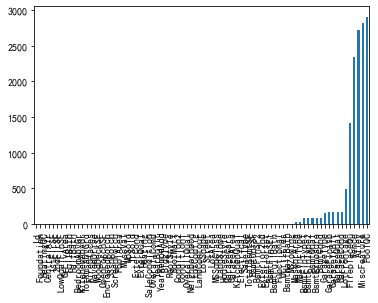

In [105]:
#处理空值
data.isnull().sum().sort_values().plot(kind = 'bar')
#删除空值率大于0.8的特征
# data[data.isnull().mean()>0.8] 错误，不能直接从data中切片
# data.isnull().mean()[data.isnull().mean()>0.8].tolist() 正确
data.drop(data.isnull().mean()[data.isnull().mean()>0.8].index.tolist(),axis = 1,inplace = True)


In [106]:
#处理空值
#分类型特征用Null补全
data.loc[:,data.dtypes[data.dtypes == 'object'].index] = \
    data.loc[:,data.dtypes[data.dtypes == 'object'].index].fillna(
    'Null')
#数值型特征用用mean（）补全
data.loc[:,data.dtypes[data.dtypes != 'object'].index] = \
    data.loc[:,data.dtypes[data.dtypes != 'object'].index].fillna(
    data.loc[:,data.dtypes[data.dtypes != 'object'].index].mean())

In [107]:
data.isnull().mean().mean()

0.0

In [108]:
#处理分类型特征
#独热编码
cat_feature = OneHotEncoder()
cat_feature = cat_feature.fit_transform(data.loc[:,data.dtypes[data.dtypes == 'object'].index])
cat_feature.todense()
cat_feature.shape
cat_feature.dtype
cat_feature.todense()

matrix([[0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.]])

In [109]:
#处理数值型特征
#标准化
num_feature = StandardScaler().fit_transform(data[data.columns[data.dtypes != 'object']])
num_feature.mean()
num_feature.std()
num_feature

array([[-1.73145754,  0.06733141, -0.20206753, ..., -0.08959196,
        -1.55218353,  0.15764553],
       [-1.7302708 , -0.87361603,  0.50187048, ..., -0.08959196,
        -0.44692486, -0.60296158],
       [-1.72908405,  0.06733141, -0.06127993, ..., -0.08959196,
         1.02675338,  0.15764553],
       ...,
       [ 1.72908405, -0.87361603,  4.25620653, ..., -0.08959196,
         1.02675338, -1.36356868],
       [ 1.7302708 ,  0.65542357, -0.34285513, ...,  1.14431218,
         0.28991426, -1.36356868],
       [ 1.73145754,  0.06733141,  0.22029527, ..., -0.08959196,
         1.7635925 , -1.36356868]])

In [158]:
#横向合并特征再纵向sample分组
feature = np.concatenate([cat_feature.todense(),num_feature],axis = 1)

In [159]:
test_feature = feature[num_train:]
train_feature = feature[0:num_train]

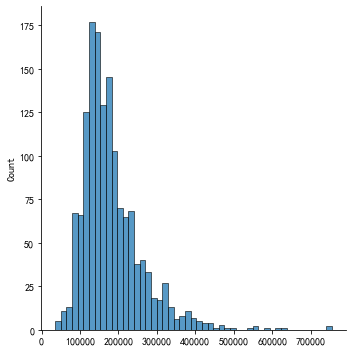

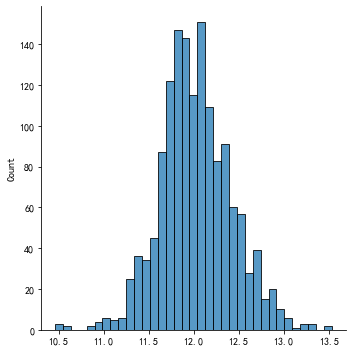

In [160]:
#标签处理：归一化（平滑分布）、标准化
sns.displot(target)
target_log1p = np.log1p(target)
sns.displot(target_log1p)

In [161]:
scaler = StandardScaler() #实例化scaler，方便后面调用 inverse_transfrom
target_log1p_scaler = scaler.fit_transform(target_log1p.reshape(-1,1))

In [162]:
target_log1p_scaler.mean()

-3.989502792050288e-15

In [163]:
target_log1p_scaler.std()

1.0

In [164]:
#建模

In [165]:
model= Ridge()

In [166]:
model = model.fit(train_feature,target_log1p_scaler)
    

In [167]:
def predict(model,feature):
    pred = model.predict(feature) 
    pred = scaler.inverse_transform(pred)
    pred = np.expm1(pred)
    return pred

In [168]:
train_pred = predict(model,train_feature)

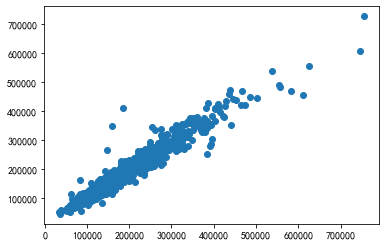

In [169]:
plt.scatter(target,train_pred)

In [170]:
np.sqrt(mse(target,train_pred))

20148.629215466673

In [171]:
test_pred = predict(model,test_feature)

In [172]:
test_pred

array([[117022.07390401],
       [145966.40778513],
       [176034.96097127],
       ...,
       [159750.84822016],
       [110948.27826042],
       [215561.50660481]])

In [173]:
sample_submission['SalePrice'] = test_pred

In [174]:
sample_submission.to_csv(r'house-prices-advanced-regression-techniques/submission.csv',index = False)

In [175]:
sample_submission.head()

,Id,SalePrice
0,1461,117022.073904
1,1462,145966.407785
2,1463,176034.960971
3,1464,196102.134925
4,1465,197647.347168


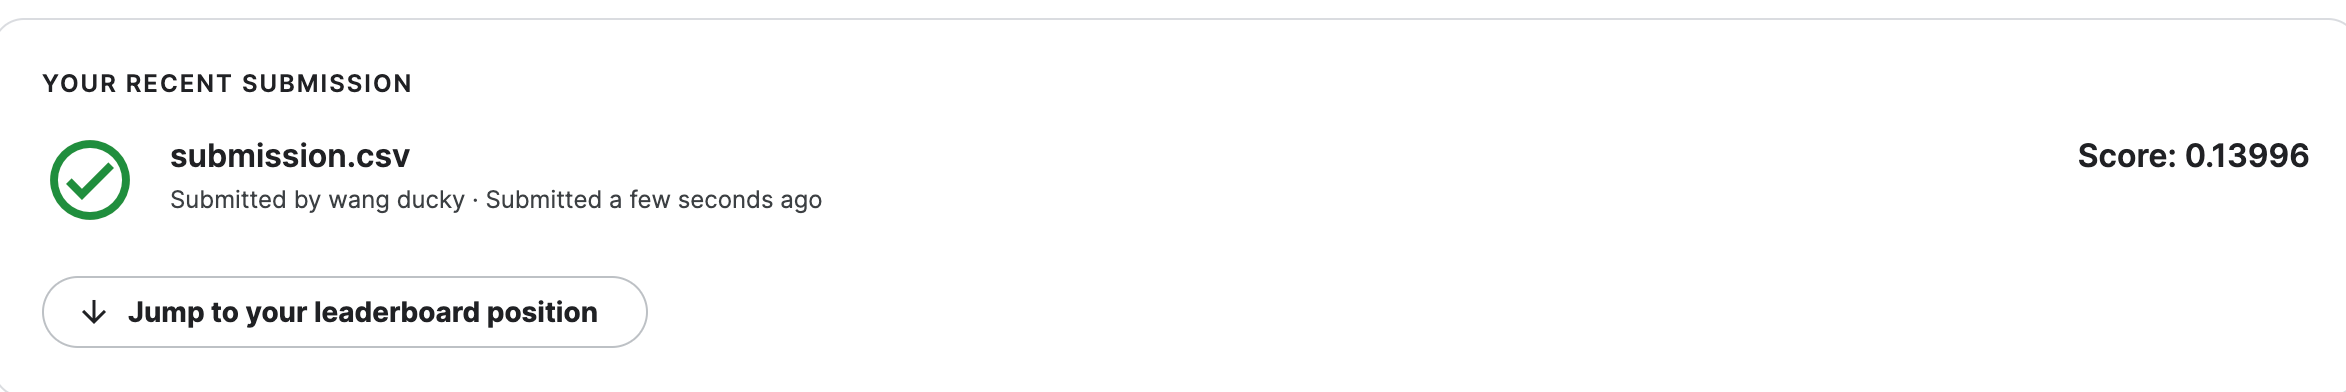